In [1]:
#载入库
import collections
import math
import os
import random
import zipfile

import numpy as np
import urllib
import tensorflow as tf


# Step 1: Download the data.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


解压压缩文件

In [3]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


# Step 2: Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
# data: 转换后的编码
# count词频统计
# reverse词汇表
# reverse_dictionary反转形式

data_index = 0

In [5]:
del words  # 节约内存

# Step 3: Function to generate a training batch for the skip-gram model.

生成Word2Vec的训练样本

In [6]:
def generate_batch(batch_size, num_skips, skip_window):
    #skip_window表示单词最远可以联系的距离，1表示只能紧邻单词才生成样本
    #num_skip表示每个单词生成多少样本,显然不能大于skip_window的两倍
    
    global data_index#因为反复调用本函数
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

测试一下：

In [7]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


# Step 4: Build and train a skip-gram model.


In [8]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.也就是说，转换为128维向量
skip_window = 1       # How many words to consider left and right.只作用于生成batch那一步
num_skips = 2         # How many times to reuse an input to generate a label.
# 每个单词生成多少个样本，只作用于生成batch那一步


# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.


graph = tf.Graph()
with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

# Step 5: Begin training.

In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  305.097198486
Nearest to can: polonaise, fullerton, durians, hana, sardar, familia, partito, typefaces,
Nearest to from: farad, obituary, putatively, tta, wanna, parenthood, overrun, consumerism,
Nearest to as: boasts, outlived, synonym, repository, bloodless, appellate, timetables, seaports,
Nearest to if: consumers, percussionist, kilowatt, mccarthy, mod, adorno, gradient, glen,
Nearest to two: greene, peano, implementations, sowed, botswana, whip, needham, ancestors,
Nearest to called: margulis, awe, djibouti, bombs, seashore, latins, parque, sigma,
Nearest to for: accordions, refounded, conscripted, drum, mccourt, ncs, jansen, halen,
Nearest to states: firmly, pins, senate, hales, forecasts, endpin, ankh, angell,
Nearest to however: scriptorium, dividing, trusting, mechanization, multiplexing, sources, powered, bough,
Nearest to been: alimony, halpin, whitcomb, levees, conventions, affiliated, paperbacks, barron,
Nearest to while: seds, rathau

Average loss at step  88000 :  4.69900344467
Average loss at step  90000 :  4.74826555884
Average loss at step  92000 :  4.70401573932
Average loss at step  94000 :  4.62092224717
Average loss at step  96000 :  4.75282068324
Average loss at step  98000 :  4.6196352607
Average loss at step  100000 :  4.6857107439
Nearest to can: may, would, will, could, should, might, must, cannot,
Nearest to from: through, into, in, during, anaheim, ssbn, at, on,
Nearest to as: when, tamarin, callithrix, reichswehr, ssbn, reginae, batavians, microcebus,
Nearest to if: when, though, where, gradient, kur, however, tamarin, but,
Nearest to two: three, four, five, six, one, seven, eight, tamarin,
Nearest to called: wct, and, microsite, lemmy, tamarin, provided, lerner, hadith,
Nearest to for: gland, when, wct, of, thaler, cebus, victoriae, with,
Nearest to states: firmly, solicitation, kingdom, endpin, domicile, fractures, pins, senate,
Nearest to however: but, although, when, that, and, callithrix, crb, w

# Step 6: Visualize the embeddings.

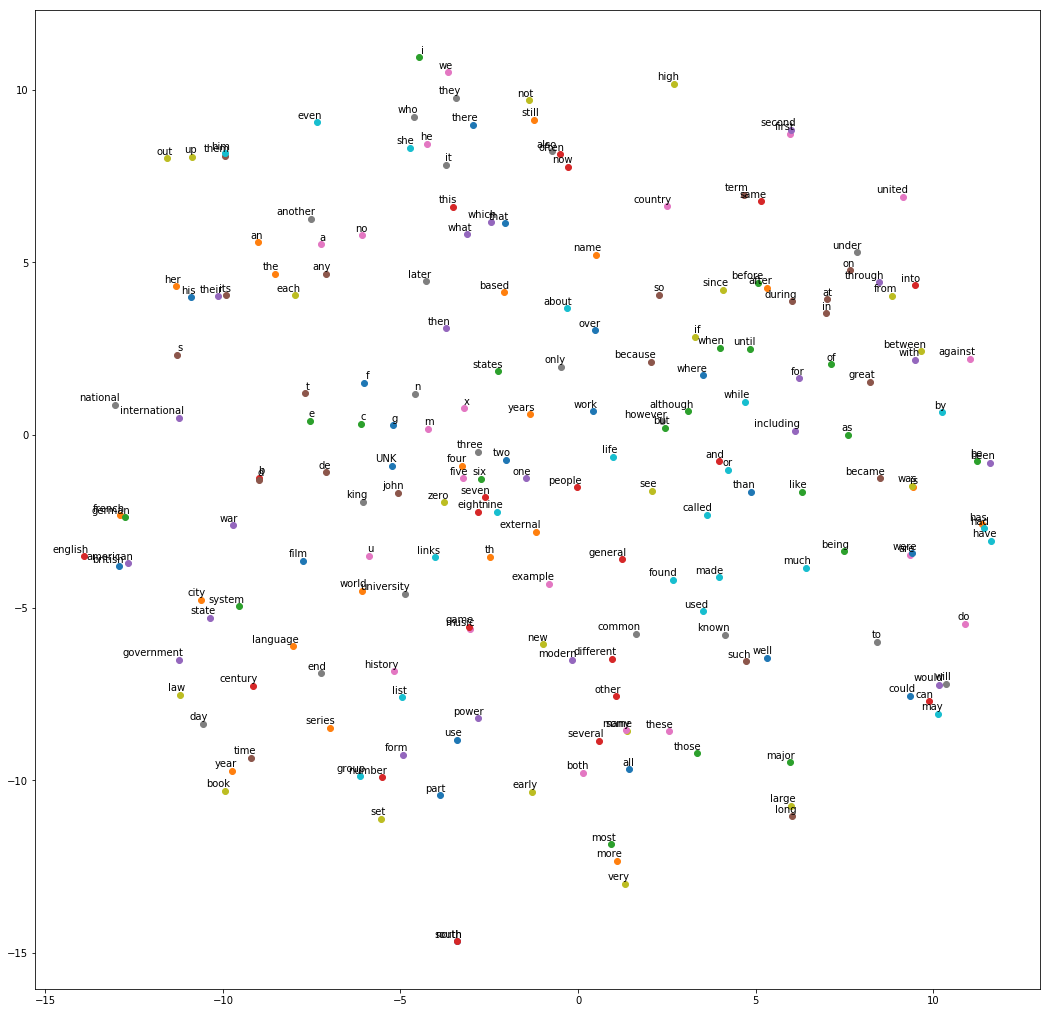

In [10]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',
                     ha='right',va='bottom')

    plt.show()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 200
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)